In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# API to fetch the dataset from Kaggle
!kaggle datasets download -d omkargurav/face-mask-dataset

 93% 151M/163M [00:00<00:00, 179MB/s]
100% 163M/163M [00:01<00:00, 162MB/s]


In [6]:
# extracting the compressed Dataset
from zipfile import ZipFile
dataset = '/content/face-mask-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [7]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/content/data')):
    subfolder_path = os.path.join('/content/data', subfolder)
    if not os.path.isdir(subfolder_path):
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00, 141.54it/s]


,image,label
0,/content/data/with_mask/with_mask_251.jpg,with_mask
1,/content/data/with_mask/with_mask_1960.jpg,with_mask
2,/content/data/with_mask/with_mask_1256.jpg,with_mask
3,/content/data/with_mask/with_mask_1115.jpg,with_mask
4,/content/data/with_mask/with_mask_2334.jpg,with_mask
...,...,...
7548,/content/data/without_mask/without_mask_1774.jpg,without_mask
7549,/content/data/without_mask/without_mask_816.jpg,without_mask
7550,/content/data/without_mask/without_mask_3080.jpg,without_mask
7551,/content/data/without_mask/without_mask_2992.jpg,without_mask


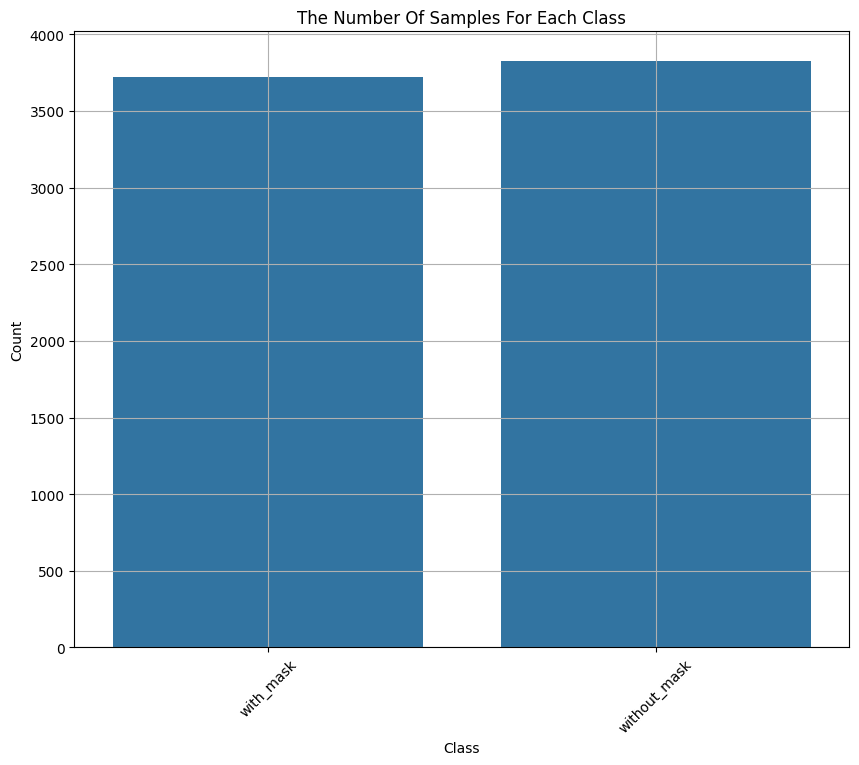

In [8]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x=df.label)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.title('The Number Of Samples For Each Class')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [9]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [11]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 5287 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.
Found 1133 validated image filenames belonging to 2 classes.


##MobileNet

In [13]:
mobilenet = tf.keras.applications.MobileNet(input_shape=(224,224,3),include_top=False)
mobilenet.trainable = False
model_MobileNet=keras.models.Sequential()
model_MobileNet.add(mobilenet)
model_MobileNet.add(keras.layers.Flatten())
model_MobileNet.add(keras.layers.Dense(256,activation=tf.nn.relu))
model_MobileNet.add(keras.layers.Dropout(.3))
model_MobileNet.add(keras.layers.Dense(2,activation=tf.nn.softmax))
model_MobileNet.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 16074690 (61.32 MB)
Trainable params: 12845

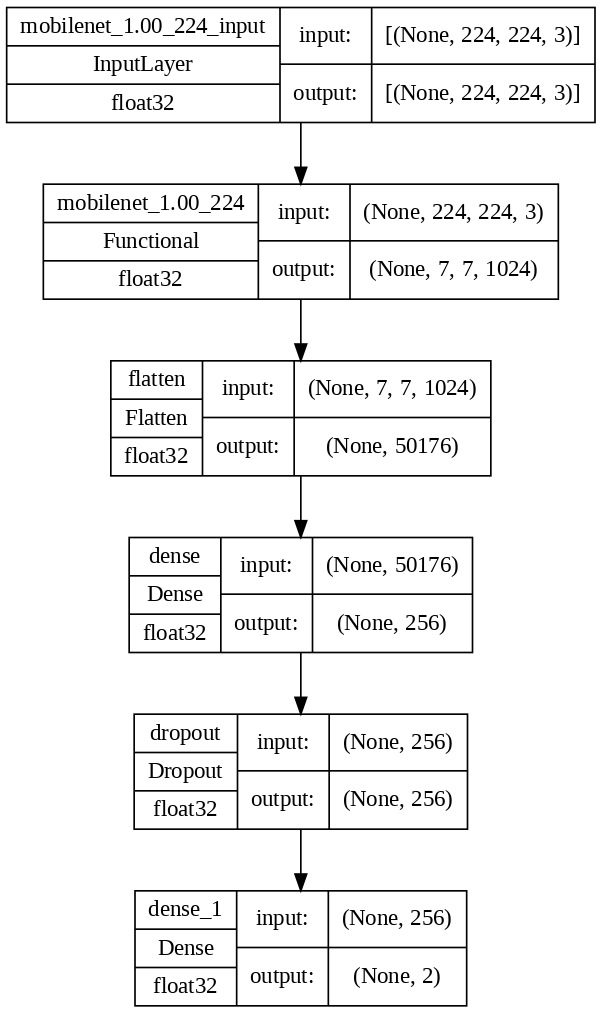

In [14]:
tf.keras.utils.plot_model(model_MobileNet, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [15]:
checkpoint_cb =ModelCheckpoint("face_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model_MobileNet.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_MobileNet = model_MobileNet.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.9824

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 23s 103ms/step - loss: 0.6638 - accuracy: 0.9824 - val_loss: 0.6451 - val_accuracy: 0.9868
Epoch 2/20
166/166 [==============================] - 15s 93ms/step - loss: 0.4132 - accuracy: 0.9907 - val_loss: 0.2085 - val_accuracy: 0.9965
Epoch 3/20
166/166 [==============================] - 15s 91ms/step - loss: 0.0535 - accuracy: 0.9974 - val_loss: 0.2143 - val_accuracy: 0.9947
Epoch 4/20
166/166 [==============================] - 15s 88ms/step - loss: 0.0479 - accuracy: 0.9981 - val_loss: 0.3312 - val_accuracy: 0.9956
Epoch 5/20
166/166 [==============================] - 15s 89ms/step - loss: 0.0653 - accuracy: 0.9985 - val_loss: 0.4628 - val_accuracy: 0.9938
Epoch 6/20
166/166 [==============================] - 15s 92ms/step - loss: 0.0620 - accuracy: 0.9983 - val_loss: 0.2193 - val_accuracy: 0.9956
Epoch 7/20
166/166 [==============================] - 15s 92ms/step - loss: 0.0652 - accuracy: 0.9985 - val_loss: 0.3427 - val_accuracy: 0.9938


In [16]:
hist_=pd.DataFrame(hist_MobileNet.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.663808,0.982410,0.645135,0.986761
1,0.413186,0.990732,0.208478,0.996470
2,0.053518,0.997352,0.214326,0.994704
3,0.047902,0.998109,0.331164,0.995587
4,0.065345,0.998487,0.462842,0.993822
5,0.062003,0.998298,0.219340,0.995587
6,0.065177,0.998487,0.342651,0.993822


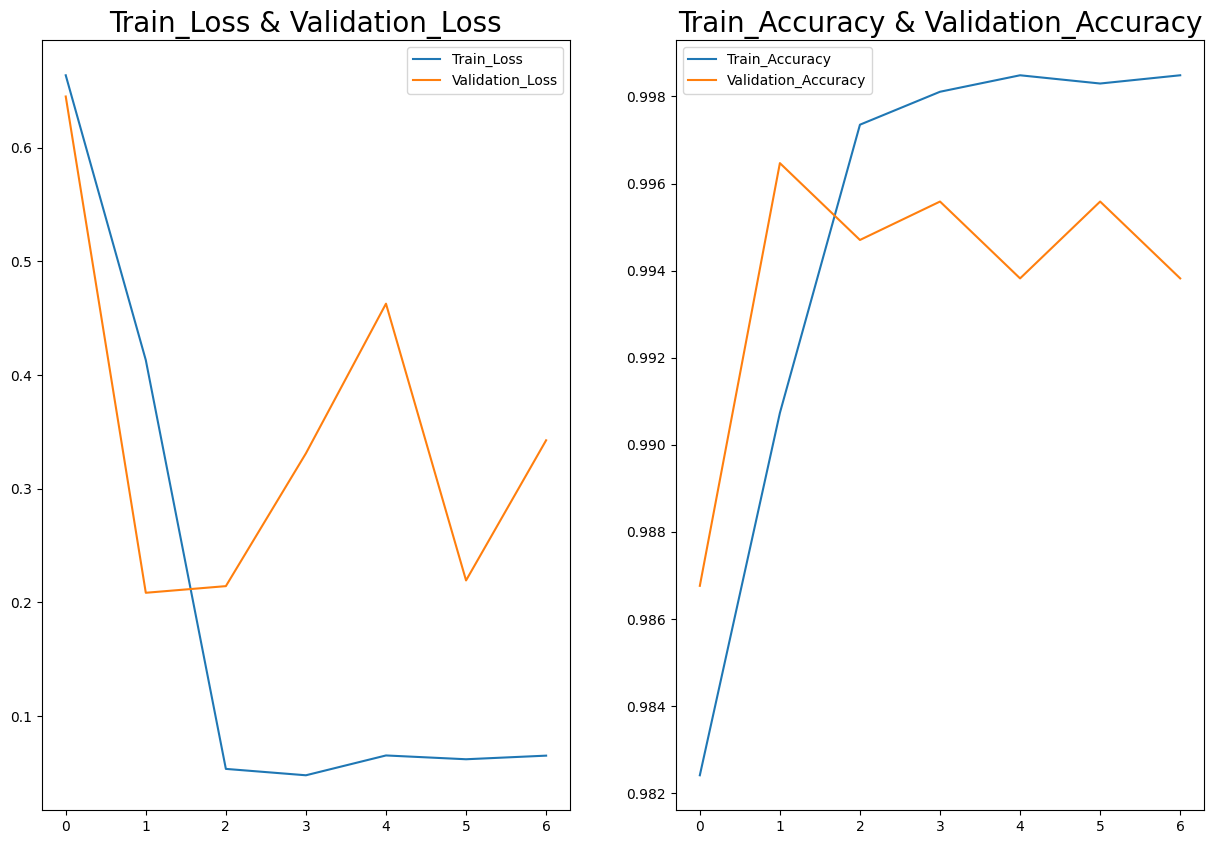

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [34]:
score, acc= model_MobileNet.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

36/36 [==============================] - 6s 157ms/step - loss: 0.4806 - accuracy: 0.8049
Test Loss = 0.4805697500705719
Test Accuracy = 0.8049426078796387


In [19]:
y_test =test_generator.classes
predictions = model_MobileNet.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

36/36 [==============================] - 6s 144ms/step


,Actual,Prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
1128,0,0
1129,1,1
1130,0,0
1131,1,1


In [20]:
class_names=['with_mask', 'without_mask']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

Output hidden; open in https://colab.research.google.com to view.

In [72]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [35]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.99      0.99       559
           1       0.99      0.99      0.99       574

    accuracy                           0.99      1133
   macro avg       0.99      0.99      0.99      1133
weighted avg       0.99      0.99      0.99      1133



##DenseNet

In [45]:
num_of_classes=2
densenet = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

for layer in densenet.layers:
    layer.trainable = False

model_DenseNet = keras.Sequential()
model_DenseNet.add(densenet)
model_DenseNet.add(keras.layers.Flatten())
model_DenseNet.add(keras.layers.Dense(128, activation='relu'))
model_DenseNet.add(keras.layers.Dropout(0.5))
model_DenseNet.add(keras.layers.Dense(64, activation='relu'))
model_DenseNet.add(keras.layers.Dropout(0.5))
model_DenseNet.add(keras.layers.Dense(num_of_classes, activation='sigmoid'))

model_DenseNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               6422656   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 2)                

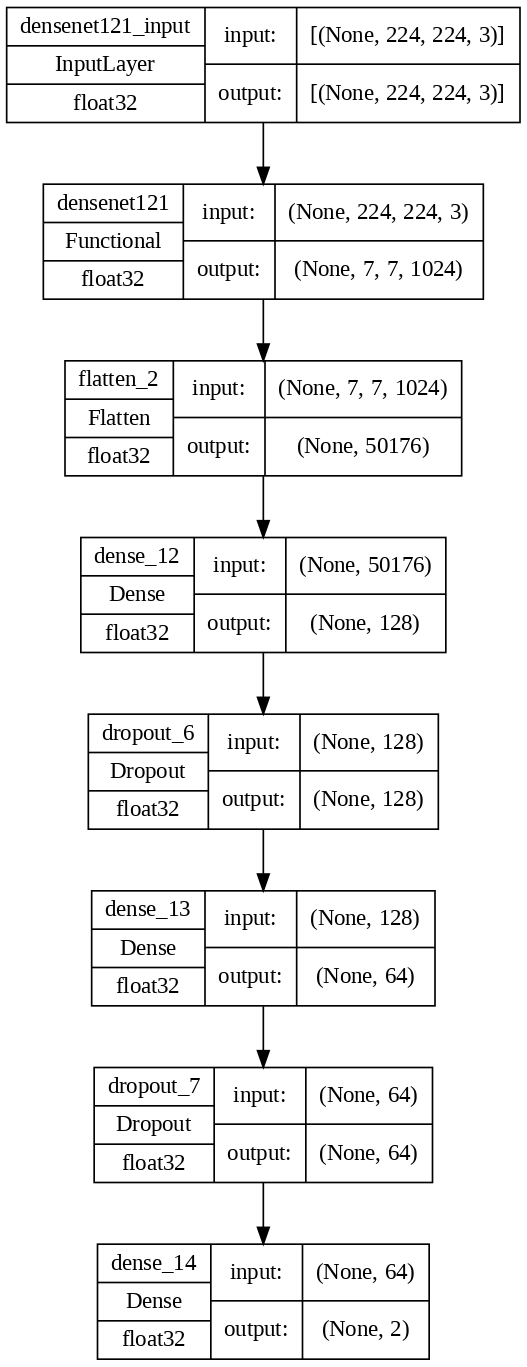

In [47]:
tf.keras.utils.plot_model(model_DenseNet, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [51]:
model_DenseNet.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
hist_DenseNet = model_DenseNet.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
  8/166 [>.............................] - ETA: 17s - loss: 0.1904 - acc: 0.9648

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 [==============================] - ETA: 0s - loss: 0.1221 - acc: 0.9790

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


166/166 [==============================] - 35s 166ms/step - loss: 0.1221 - acc: 0.9790 - val_loss: 0.0264 - val_acc: 0.9947
Epoch 2/20
166/166 [==============================] - 22s 132ms/step - loss: 0.1131 - acc: 0.9788 - val_loss: 0.0487 - val_acc: 0.9929
Epoch 3/20
166/166 [==============================] - 20s 121ms/step - loss: 0.1132 - acc: 0.9756 - val_loss: 0.0483 - val_acc: 0.9956
Epoch 4/20
166/166 [==============================] - 20s 122ms/step - loss: 0.0512 - acc: 0.9813 - val_loss: 0.0351 - val_acc: 0.9947
Epoch 5/20
166/166 [==============================] - 20s 120ms/step - loss: 0.0371 - acc: 0.9892 - val_loss: 0.0556 - val_acc: 0.9947
Epoch 6/20
166/166 [==============================] - 20s 122ms/step - loss: 0.0353 - acc: 0.9885 - val_loss: 0.0511 - val_acc: 0.9965


In [54]:
hist1_=pd.DataFrame(hist_DenseNet.history)
hist1_

,loss,acc,val_loss,val_acc
0,0.122082,0.979005,0.026437,0.994704
1,0.113094,0.978816,0.048651,0.992939
2,0.113234,0.975601,0.048306,0.995587
3,0.051204,0.981275,0.035149,0.994704
4,0.037057,0.989219,0.055604,0.994704
5,0.035291,0.988462,0.051100,0.996470


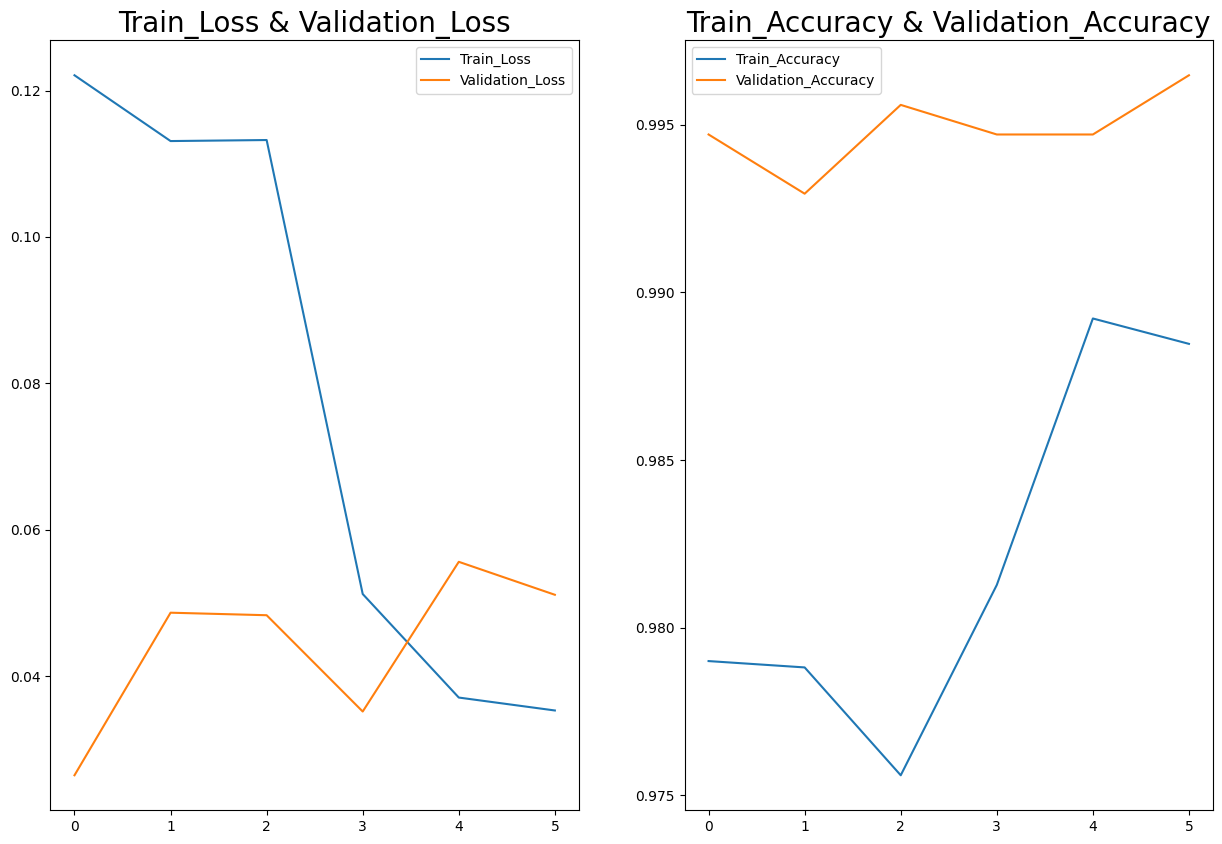

In [56]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist1_['loss'],label='Train_Loss')
plt.plot(hist1_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist1_['acc'],label='Train_Accuracy')
plt.plot(hist1_['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [57]:
score, acc= model_DenseNet.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

36/36 [==============================] - 4s 96ms/step - loss: 0.0552 - acc: 0.9956
Test Loss = 0.055191993713378906
Test Accuracy = 0.9955869317054749


In [65]:
y_test =test_generator.classes
predictions = model_DenseNet.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

36/36 [==============================] - 3s 93ms/step


,Actual,Prediction
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
1128,0,0
1129,1,1
1130,0,0
1131,1,1


In [75]:
class_names=['with_mask', 'without_mask']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

Output hidden; open in https://colab.research.google.com to view.

In [76]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [77]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [ ]:
y_pred = model_DenseNet.predict(test_generator)

threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

Y_test_categorical = np.argmax(Y_test, axis=1)

cm = confusion_matrix(Y_test_categorical, np.argmax(y_pred_binary, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Without Mask", "With Mask"])
disp.plot(cmap='Blues', values_format='d')

plt.title('Confusion Matrix')
plt.show()